In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from matplotlib import colors
import scipy.io.wavfile as wavfile
from scipy.signal import spectrogram
import os
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import numpy.fft
import librosa
from scipy.stats import zscore
from sklearn.model_selection import GridSearchCV, KFold
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [2]:
dev_path = 'dsl_data/development.csv'
eval_path = 'dsl_data/evaluation.csv'

In [3]:
def load_dataframe(path):
    df = pd.read_csv(path)
    # Dataframe exploration
    print('***** DATAFRAME INFO *****\n')
    print(df.info())
    print('\n\n***** HEAD *****\n')
    print(df.head())
    if('action' in df.columns):
        print('\n\n ***** POSSIBLE CLASSIFICATION OUTCOMES *****\n')
        print(df.groupby(['action', 'object']).size())
    sampleRates = list()
    audios = list()
    for i in range(0, df.shape[0]):
        audio_path = df['path'].loc[i]
        sr, audio = get_sr_audio(audio_path)
        sampleRates.append(sr)
        audios.append(audio.astype(np.float32))
    df['SampleRates'] = sampleRates
    df['AudioData'] = audios
    print('\n\n ***** SAMPLE RATES *****')
    print(df['SampleRates'].value_counts())
    
    print('\n\n ***** Self-reported fluency level *****')
    print(df['Self-reported fluency level '].value_counts())
    
    print('\n\n ***** First Language spoken *****')
    print(df['First Language spoken'].value_counts())
    
    print('\n\n ***** Current language used for work/school *****')
    print(df['Current language used for work/school'].value_counts())
    
    print('\n\n ***** Gender *****')
    print(df['gender'].value_counts())
    print('\n\n ***** Age range *****')
    print(df['ageRange'].value_counts())
    return df

def get_sr_audio(filepath):
    sr, audio = wavfile.read(filepath)
    return sr, audio



def edit_sample_rates(df, goal_sr):
    all_audios = list()
    all_srs = list()
    for index, row in df.iterrows():
    # Load the audio file
        sr = row['SampleRates']
        audio = row['AudioData']
    # Check if the sample rate is equal to the target sample rate
        if sr==goal_sr:
            all_audios.append(audio)
            all_srs.append(sr)
        else:
        # Convert the sample rate to the target sample rate
            resampled_audio = librosa.resample(audio, orig_sr=sr, target_sr=goal_sr)
            all_audios.append(resampled_audio)
            all_srs.append(goal_sr)
    df['AudioData']=all_audios
    df['SampleRates']=all_srs
    print('Sample rates after resampling:\n', df['SampleRates'].value_counts())

# definition of functions to represent each audio 

def plot_spectrogram(audio_data, sr):
    frequencies, times, spec = spectrogram(audio_data, fs=sr)
    plt.pcolormesh(times, frequencies, 10*np.log10(spec)) #changed the scale to dB
    plt.colorbar()
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.grid(True)
    plt.show()
    


def plot_time_dimension(audio_data, sr):
    audioArray = np.array(audio_data)
    duration = len(audioArray) / sr
    # Create the time axis in seconds
    time = np.linspace(0, duration, len(audioArray))
    plt.plot(time, audioArray)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()
    
def plot_freq_dimension(audio_data, sr):
    audioArray = np.array(audio_data)
    freqArray = np.abs(np.fft.fft(audioArray))
    decibels = 20 * np.log10(freqArray)
    plt.figure(figsize=(10,4))
    plt.plot(decibels)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.grid(True)
    plt.show()
    

def clean_df(df):
    #ordinal encoding of categorical features
    catFeatures = ['Self-reported fluency level ', 'First Language spoken', 'Current language used for work/school', 'gender', 'ageRange']
    dicts = list()
    dic_fluency = {'native' : 0, 'advanced' : 1, 'intermediate':2, 'basic': 3}
    dicts.append(dic_fluency)
    dic_first_lan = {'English (United States)': 0, 'English (Canada)': 1, 'French (Canada)' : 2, 'Spanish (Venezuela)':3, 'Telugu':4 }
    dicts.append(dic_first_lan)
    dic_current = {'English (United States)': 0, 'English (Canada)': 1, 'English (Australia)' : 2, 'Spanish (Venezuela)':3 }
    dicts.append(dic_current)
    dic_gender = {'female': 0, 'male': 1 }
    dicts.append(dic_gender)
    dic_age = {'22-40':0, '41-65':1, '65+': 3}
    dicts.append(dic_age)
    for i in range(0, len(catFeatures)):
        dic = dicts[i]
        feat = catFeatures[i]
        df[feat] = df[feat].replace(dic)
    return df

In [4]:
df = load_dataframe(dev_path)

***** DATAFRAME INFO *****

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9854 entries, 0 to 9853
Data columns (total 10 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   Id                                     9854 non-null   int64 
 1   path                                   9854 non-null   object
 2   speakerId                              9854 non-null   object
 3   action                                 9854 non-null   object
 4   object                                 9854 non-null   object
 5   Self-reported fluency level            9854 non-null   object
 6   First Language spoken                  9854 non-null   object
 7   Current language used for work/school  9854 non-null   object
 8   gender                                 9854 non-null   object
 9   ageRange                               9854 non-null   object
dtypes: int64(1), object(9)
memory usage: 770.0+ KB
None


**

In [5]:
target_rate = 16000
edit_sample_rates(df, target_rate) #bring all srs to 16kHz

Sample rates after resampling:
 16000    9854
Name: SampleRates, dtype: int64


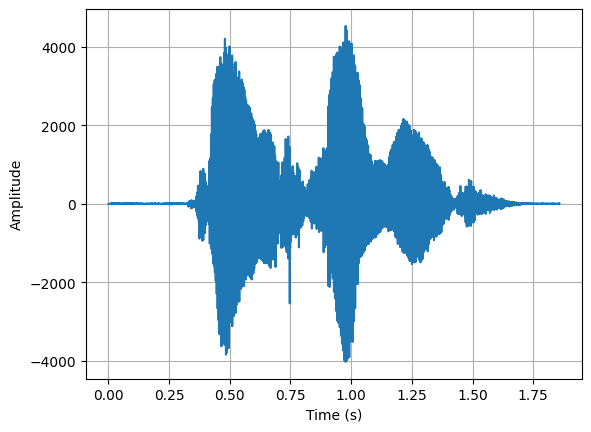

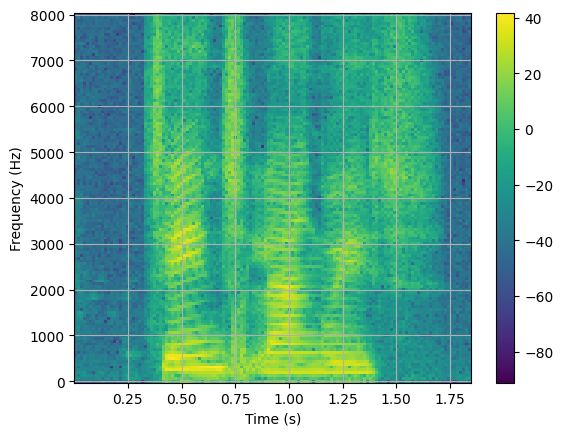

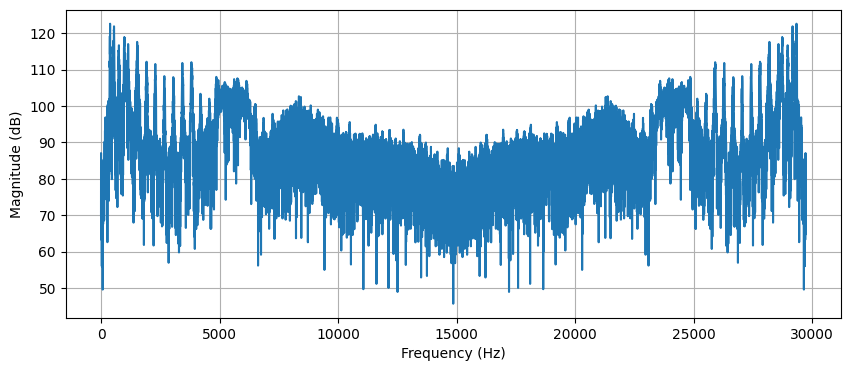

In [6]:
# plotting the first audio in the df
audio_data = df['AudioData'].loc[0]
sr = df['SampleRates'].loc[0]

plot_time_dimension(audio_data, sr)
plot_spectrogram(audio_data, sr)
plot_freq_dimension(audio_data, sr)


In [7]:
df = clean_df(df)

In [8]:
df.head()

,Id,path,speakerId,action,object,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange,SampleRates,AudioData
0,0,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0a312...,2BqVo8kVB2Skwgyb,change language,none,1,0,0,0,0,16000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0ee42...,2BqVo8kVB2Skwgyb,activate,music,1,0,0,0,0,16000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/1d9f3...,2BqVo8kVB2Skwgyb,deactivate,lights,1,0,0,0,0,16000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/269fc...,2BqVo8kVB2Skwgyb,increase,volume,1,0,0,0,0,16000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/5bbda...,2BqVo8kVB2Skwgyb,increase,volume,1,0,0,0,0,16000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [9]:
def plot_all_audios(df):
    fig, ax = plt.subplots(1,1)
    for ind in range(0, len(df)):
        audio = df['AudioData'].loc[ind]
        sr = df['SampleRates'].loc[ind]
        audioArray = np.array(audio)
        duration = len(audio) / sr
        time = np.linspace(0, duration, len(audio))
        ax.plot(time, audioArray)
    ax.set_ylabel("Amplitude")
    ax.set_xlabel("Time [s]")
    plt.grid(True)
    plt.show()
    
  

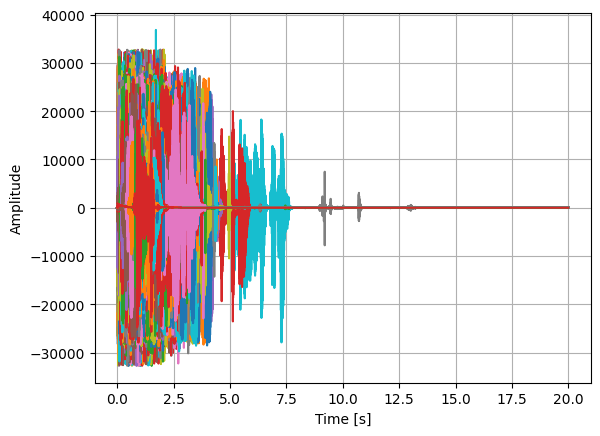

In [10]:
plot_all_audios(df)

In [11]:
# By normalising the amplitude of the audios it is possible 
#to lower the impact of different recording conditions:

def normalise_audios(df):
    normalised = list()
    for idx, rec in df.iterrows():
        normalised.append(zscore(rec['AudioData']))
    df['AudioData'] = normalised
    return df

In [12]:
df = normalise_audios(df)

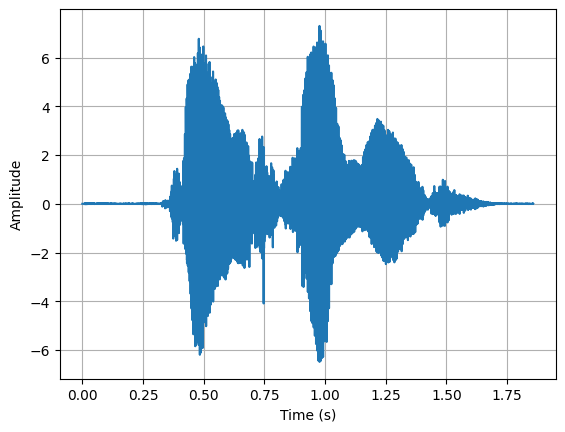

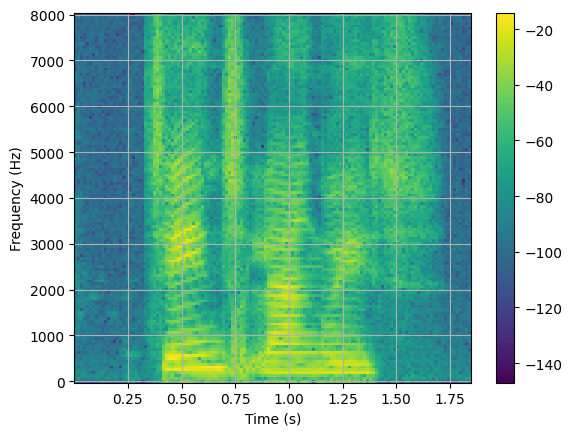

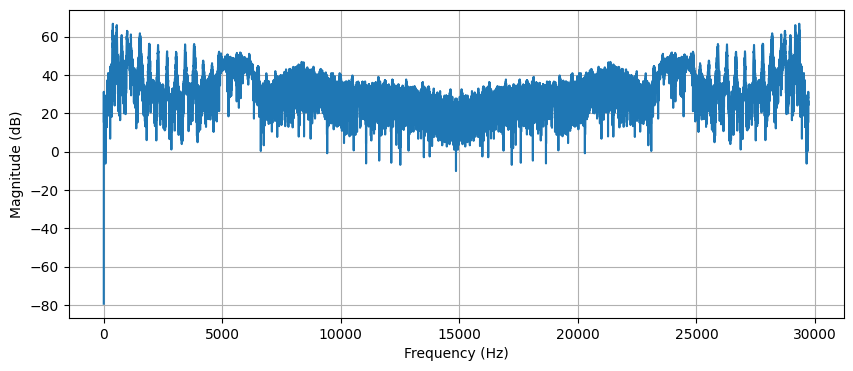

In [13]:
# plotting the first audio in the df
audio_data = df['AudioData'].loc[0]
sr = df['SampleRates'].loc[0]

plot_time_dimension(audio_data, sr)
plot_spectrogram(audio_data, sr)
plot_freq_dimension(audio_data, sr)


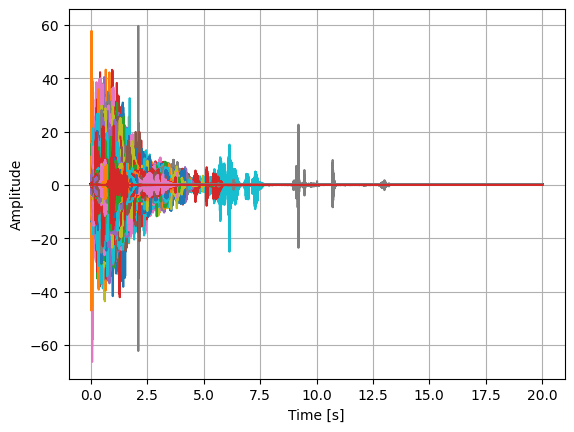

In [14]:
plot_all_audios(df)

In [15]:
def plot_duration_histogram(df):
    recList = []
    lenList = []

    for idx, row in df.iterrows():
        rec = row['AudioData']
        sr = row['SampleRates']
        recList.append(rec)
        lenList.append(len(rec)/sr)

    plt.xlabel('Seconds')
    plt.ylabel('Frequency')
    plt.grid(True)
    hist_array = plt.hist(np.array(lenList), bins='auto', color='#0504aa', alpha=0.7, rwidth=1)

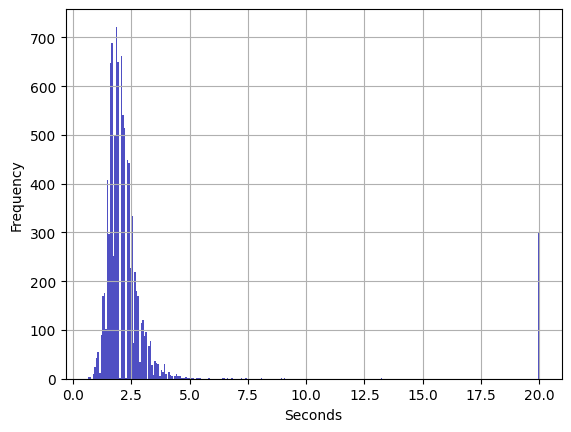

In [16]:
plot_duration_histogram(df)

In [17]:
def standardise_length(df, seconds):

    recListAdj = []
    lenListAdj = []

    for idx, row in df.iterrows():
        rec = row['AudioData']
        sr = row['SampleRates']
        rec, index = librosa.effects.trim(rec, top_db=30)
        threshold = sr * seconds 
        if len(rec) > threshold:
            rec = rec[:threshold]
        recListAdj.append(rec)
        lenListAdj.append(len(rec)/sr)
    df['AudioData'] = recListAdj
    return df

In [18]:
df = standardise_length(df, 3)


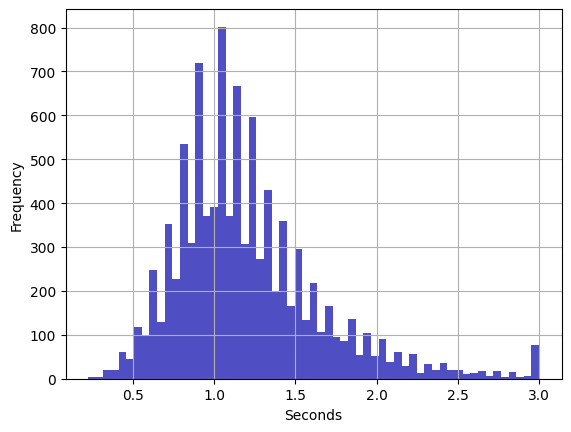

In [19]:
plot_duration_histogram(df)

In [20]:
def plot_split_spectrogram(audio, sr, n_blocks):
    frequencies, times, spec = spectrogram(audio, fs=sr)
    times = (times * 1000).astype(int) #milliseconds
    frequencies = frequencies.astype(int)
    fig, ax = plt.subplots(1,1)
    plt.pcolormesh(times, frequencies, 10*np.log10(spec)) #changed the scale to dB
    plt.colorbar()
    time_bounds = list()
    freq_bounds = list()
    #n_blocks is the same vertically and horizontally
    #starting from vertical lines to create time bins:
    v_step = int(times[len(times)-1] / n_blocks)
    
    for v in range(0, times[len(times)-1], v_step):
        ax.axvline(v, color = 'red')
        time_bounds.append(v)
    #and then horizontal lines to create frequency bins:
    h_step = int(frequencies[len(frequencies)-1]/n_blocks)
    for h in range(0, frequencies[len(frequencies)-1], h_step):
        ax.axhline(h, color = 'red')
        freq_bounds.append(h)
    plt.xlabel("Time (ms)")
    plt.xlim(left=0)
    plt.ylabel("Frequency (Hz)")
    plt.show()

def split_spectrogram(audio, sr, n_blocks):
    frequencies, times, spec = spectrogram(audio, fs=sr)
    times = (times * 1000).astype(int) #milliseconds
    frequencies = frequencies.astype(int)
        
    
    # Split the matrix into sub-arrays of size N along the first axis (rows)
    rows_blocks = np.array_split(spec, n_blocks, axis=0)
    #this is a list: each element of the list is a sub-matrix obtained slicing horizontally the spectrogram
    # into n_blocks slices

    # Split the sub_matrices into sub-arrays of size NxN along the second axis (columns)
    blocks = [ np.array_split(block, n_blocks, axis=1) for block in rows_blocks]
    #This is, instead, a list of lists: the first element is a list containing all the blocks obtained from 
    #the first vertical slice


    # Initialize arrays to store the mean and standard deviation of each block
    block_means = np.zeros((n_blocks,n_blocks))
    block_stds = np.zeros((n_blocks,n_blocks))
    

    

    # Iterate over blocks
    for i in range(0, n_blocks):
        for j in range(0, n_blocks):
            # Compute mean and standard deviation of the block
             #i is the index of the horizontal split  (indicating which column)
            block = blocks[i][j] #j is the index of the vertical split (indicating which row)
            mean = np.mean(block)
            std = np.std(block)
            block_means[i,j] = mean
            block_stds[i,j] = std
    return block_means.tolist(), block_stds.tolist(), blocks

In [21]:
#adding the statistics of the blocks into the dataframe

def add_stats_df(df,sr,n_blocks):
    for i in range(0,n_blocks):
        for j in range(0, n_blocks):
            idx = j+n_blocks*i
            col_name_mean = 'block_mean_'+str(idx)
            col_name_dev = 'block_dev_'+str(idx)
            df[col_name_mean] = ''
            df[col_name_dev] = ''
    all_means = list()
    all_std_devs = list()


    for index, row in df.iterrows():
        audio = row['AudioData']
        meanTemp, stdTemp, blocksTemps = split_spectrogram(audio, sr, n_blocks)
        for i in range(0,n_blocks):
            for j in range(0, n_blocks):
                idx = j+n_blocks*i
                col_name_mean = 'block_mean_'+str(idx)
                col_name_dev = 'block_dev_'+str(idx)
                df.loc[index, col_name_mean] = meanTemp[i][j]
                df.loc[index, col_name_dev] = stdTemp[i][j]
        
   


In [22]:
label_dictionary = {'increase volume': 0, 'decrease volume': 1, 'increase heat': 2, 'decrease heat':3, 'change language none':4,'activate music':5, 'deactivate lights':6 }


In [ ]:
df0 = df.copy()
acc_basic_rf = list()
for n in range(2,16,2):
    add_stats_df(df0, 16000, n)
    y = df0['action'] + ' ' + df0['object']
    y = y.replace(label_dictionary)
    X = df0.drop(['action', 'object', 'path', 'speakerId', 'AudioData'], axis = 1) 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=31)
    rf_basic = RandomForestClassifier()
    rf_basic.fit(X_train,y_train)
    acc_rf = accuracy_score(y_test, rf_basic.predict(X_test))
    acc_basic_rf.append(acc_rf)


In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(range(2,16,2), acc_basic_rf)
plt.xlabel("n")
plt.ylabel("accuracy")
plt.grid(True)

In [ ]:
# random forest hyperparameters:
RF_params = {
    'n_estimators' : [50, 100, 200, 300],
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [10, 20, 50, 100, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10]
}


In [ ]:
df1 = df.copy() #working with a new copy of the original df
n=14
add_stats_df(df1, 16000, n)
y = df1['action'] + ' ' + df1['object']
y = y.replace(label_dictionary)
X = df1.drop(['action', 'object', 'path', 'speakerId', 'AudioData'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=31)
accuracies_rf = list()
configs_rf = list()
for config in ParameterGrid(RF_params):
    print(config)
    rf = RandomForestClassifier(**config)
    rf.fit(X_train, y_train)
    acc = accuracy_score(y_test, rf.predict(X_test))
    accuracies_rf.append(acc)
    configs_rf.append(config)
max_val = max(accuracies_rf)
max_idx = accuracies_rf.index(max_val)
best_conf = configs_rf[max_idx]
print('The best accuracy for ', n, ' blocks is ', max_val , ' obtained with the configuration ', best_conf)


In [ ]:
eval_df = load_dataframe(eval_path)


In [ ]:
# X, y to train the classifiers
add_stats_df(df, 16000, 14)
y = df['action'] + ' ' + df['object']
y = y.replace(label_dictionary)
X = df.drop(['action', 'object', 'path', 'speakerId', 'AudioData', 'SampleRates'], axis = 1)


In [ ]:

# eval_df must have the same features of the df used for the training of the classifiers
target_rate = 16000
edit_sample_rates(eval_df, target_rate) #bring all srs to 16kHz
eval_df = normalise_audios(eval_df)
eval_df = standardise_length(eval_df, 3)

add_stats_df(eval_df, target_rate, 14)

eval_X = eval_df.drop(['path', 'speakerId', 'AudioData', 'SampleRates'], axis = 1)



In [ ]:
eval_X = clean_df(eval_X)

In [ ]:
rf = RandomForestClassifier(criterion='entropy', max_depth=100,min_samples_leaf=1, min_samples_split=5, n_estimators=300)
rf.fit(X, y)
eval_y_rf = rf.predict(eval_X)

In [ ]:
inverse_dict = {0: 'increasevolume', 1: 'decreasevolume',2: 'increaseheat',3: 'decreaseheat',4: 'changelanguagenone',5: 'activatemusic',6: 'deactivatelights'}

solution_rf = pd.DataFrame(eval_y_rf, index = eval_X.index, columns = ['Predicted'])
solution_rf['Predicted'].replace(inverse_dict, inplace=True)

solution_rf.head()

In [ ]:
solution_rf.to_csv('draft_solution_rf.csv', sep=',', index_label='Id')

In [ ]:
rf_naive = RandomForestClassifier()
rf_naive.fit(X, y)
eval_y_rf_naive = rf_naive.predict(eval_X)

In [ ]:
solution_rf_naive = pd.DataFrame(eval_y_rf_naive, index = eval_X.index, columns = ['Predicted'])
solution_rf_naive['Predicted'].replace(inverse_dict, inplace=True)

solution_rf_naive.head()

In [ ]:
solution_rf_naive.to_csv('draft_solution_rf_naive.csv', sep=',', index_label='Id')